<a href="https://colab.research.google.com/github/pratikMunavalli09/rain-removal-autoencoder/blob/main/De_raining_dl_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch torchvision Pillow

In [1]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import numpy as np
import cv2

In [2]:
# Function to list only valid image files
def list_image_files(directory):
    return [f for f in os.listdir(directory) if not f.startswith('.')]  # Exclude hidden files

# Define paths to train and test directories
train_rain_path = "/content/rain100H/train/rain"
train_norain_path = "/content/rain100H/train/norain"
test_rain_path = "/content/rain100H/test/rain"
test_norain_path = "/content/rain100H/test/norain"

In [3]:
# Define a custom Dataset class to load paired images
class Rain100HDataset(Dataset):
    def __init__(self, rain_dir, clean_dir, transform=None):
        self.rain_dir = rain_dir
        self.clean_dir = clean_dir
        self.transform = transform
        self.rain_images = [img for img in os.listdir(rain_dir) if img != ".ipynb_checkpoints"]
        self.clean_images = [img for img in os.listdir(clean_dir) if img != ".ipynb_checkpoints"]

        # Ensure the number of rainy and clean images match
        assert len(self.rain_images) == len(self.clean_images), "Mismatch in number of rainy and clean images"

    def __len__(self):
        return len(self.rain_images)

    def __getitem__(self, idx):
        rain_img_path = os.path.join(self.rain_dir, self.rain_images[idx])
        clean_img_path = os.path.join(self.clean_dir, self.clean_images[idx])

        # Load the images
        rain_img = Image.open(rain_img_path).convert("RGB")
        clean_img = Image.open(clean_img_path).convert("RGB")

        # Apply transformations if any
        if self.transform:
            rain_img = self.transform(rain_img)
            clean_img = self.transform(clean_img)

        return rain_img, clean_img

In [4]:
# Define preprocessing transformations (resize, augmentations, normalize)
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resizing to the fixed size (can adjust as needed)
    transforms.RandomHorizontalFlip(),  # Data Augmentation: Random horizontal flip
    transforms.RandomRotation(15),  # Data Augmentation: Random rotation
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

In [5]:
# Create train and test datasets
train_dataset = Rain100HDataset(rain_dir=train_rain_path, clean_dir=train_norain_path, transform=transform)
test_dataset = Rain100HDataset(rain_dir=test_rain_path, clean_dir=test_norain_path, transform=transform)

# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

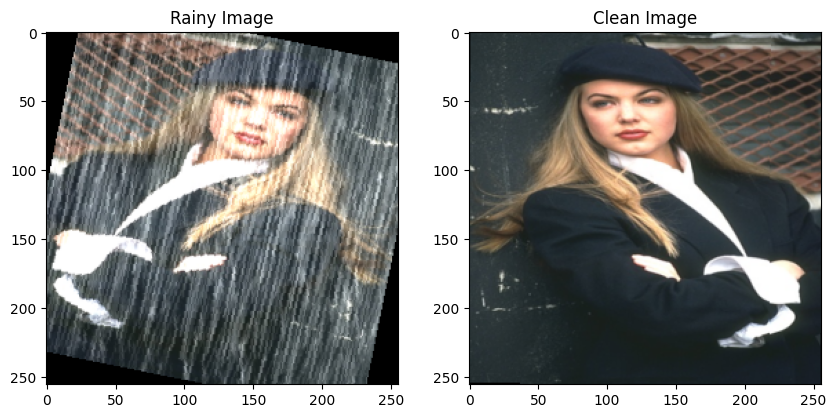

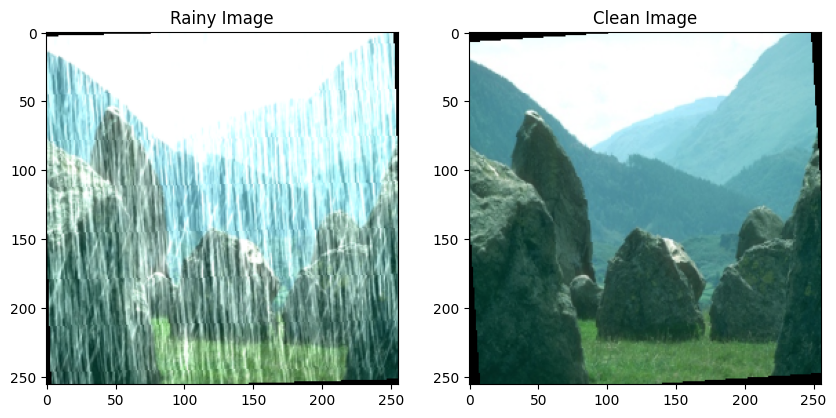

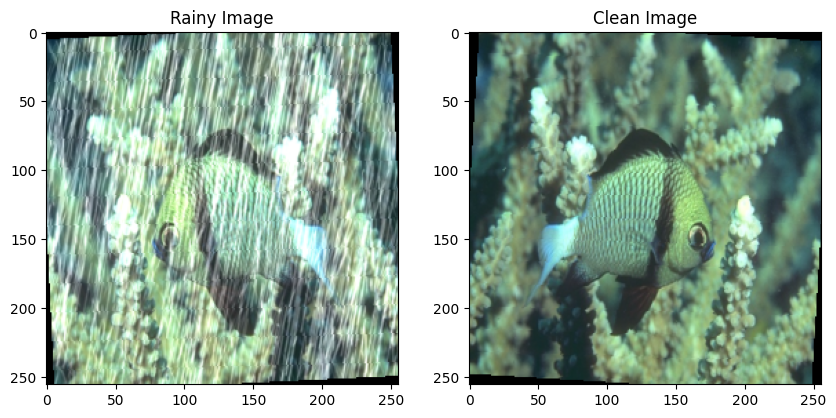

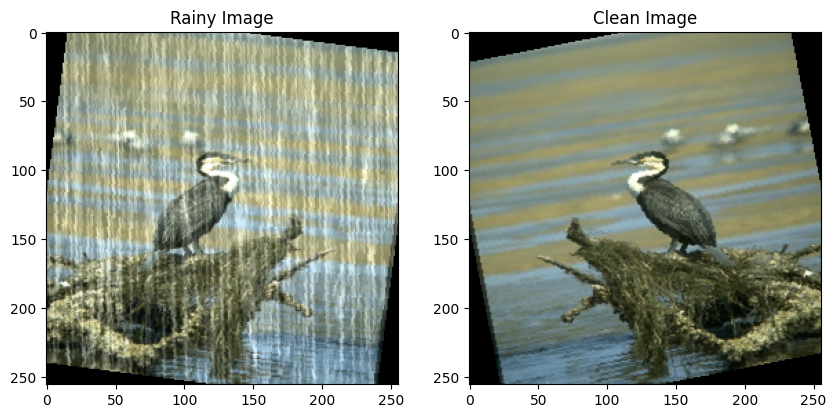

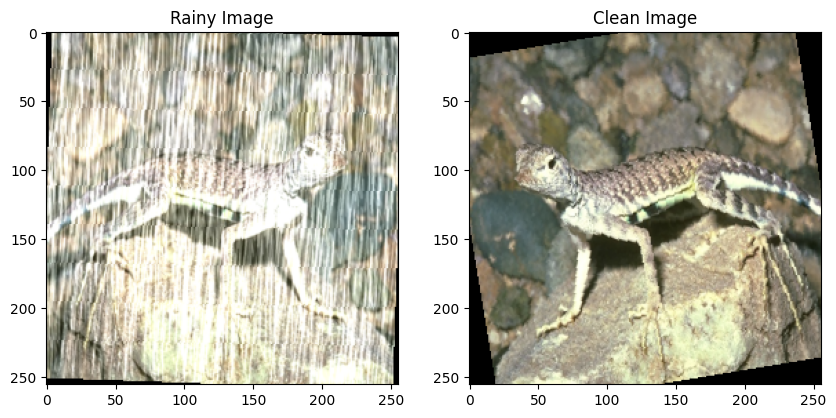

In [6]:
# Function to display random image pairs before preprocessing
def display_images_before_preprocessing(dataset, num_images=5):
    for i in range(num_images):
        rain_img, clean_img = dataset[i]

        # Convert tensors back to images (scale from [-1, 1] to [0, 1])
        rain_img_np = (rain_img.permute(1, 2, 0).numpy() * 0.5) + 0.5
        clean_img_np = (clean_img.permute(1, 2, 0).numpy() * 0.5) + 0.5

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(rain_img_np)
        axes[0].set_title("Rainy Image")
        axes[1].imshow(clean_img_np)
        axes[1].set_title("Clean Image")
        plt.show()

# Display some images before preprocessing
display_images_before_preprocessing(train_dataset, num_images=5)

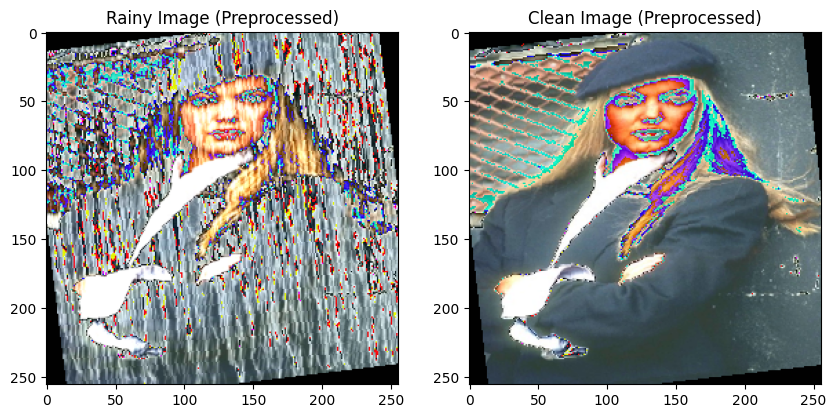

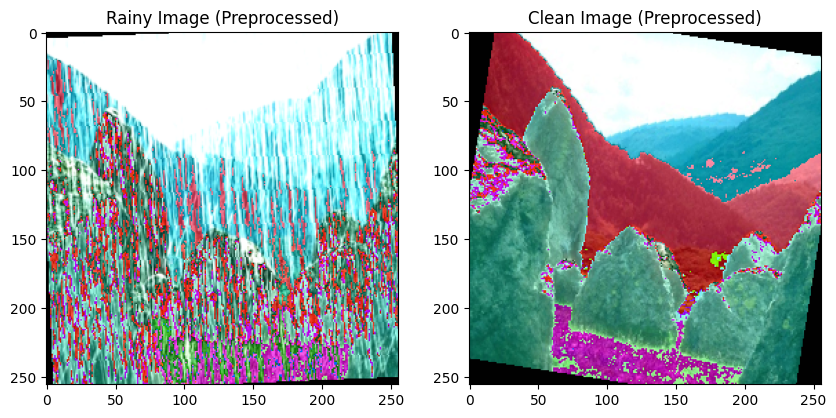

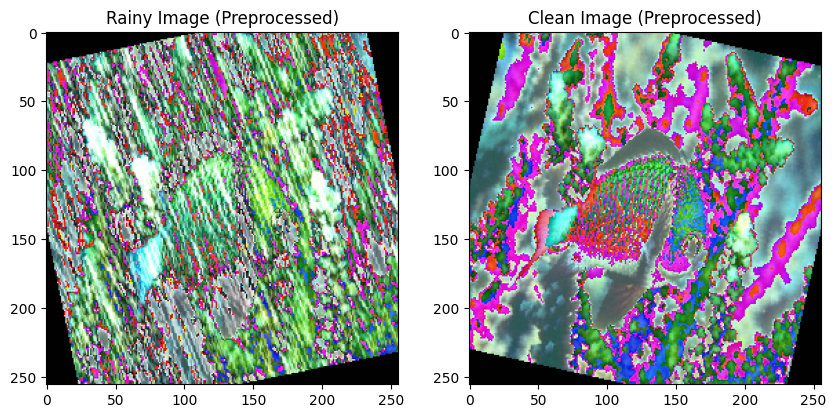

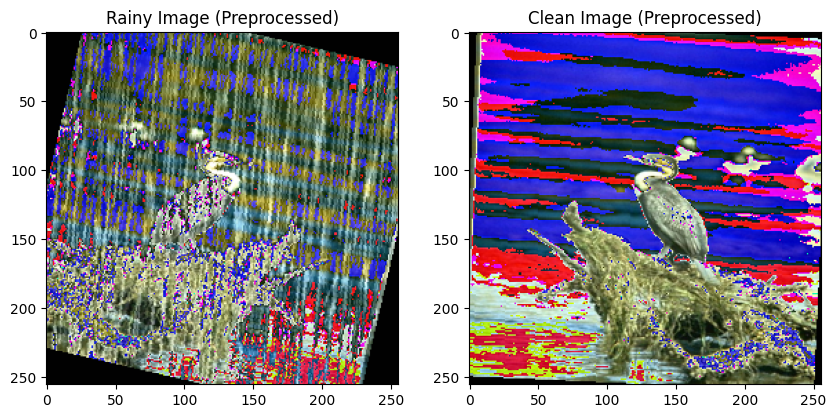

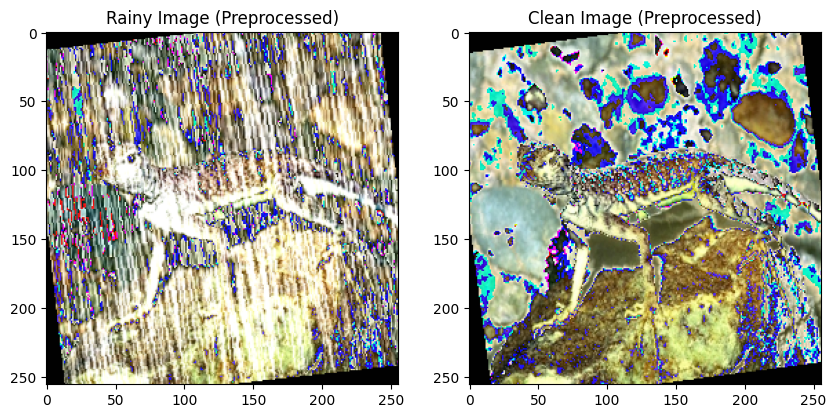

In [7]:
# EDA: Visualize a few images after preprocessing
def show_images(dataset, num_images=5):
    for i in range(num_images):
        rain_img, clean_img = dataset[i]
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(transforms.ToPILImage()(rain_img))
        axes[0].set_title("Rainy Image (Preprocessed)")
        axes[1].imshow(transforms.ToPILImage()(clean_img))
        axes[1].set_title("Clean Image (Preprocessed)")
        plt.show()

# Show 5 image pairs from the training set
show_images(train_dataset, num_images=5)

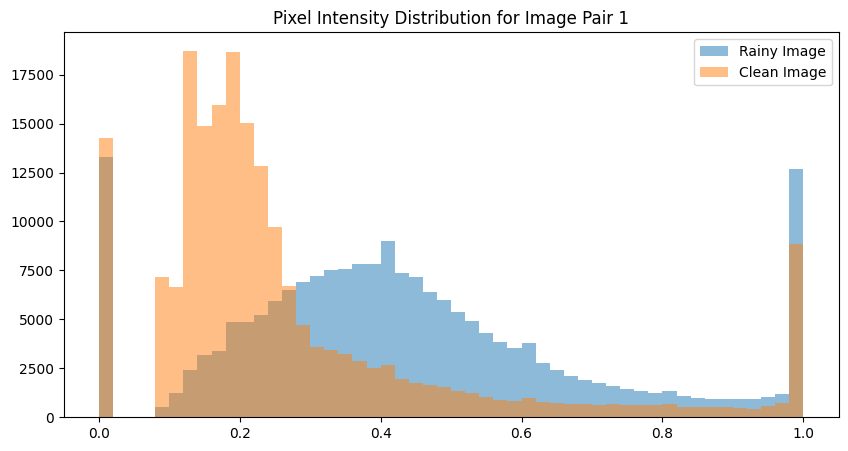

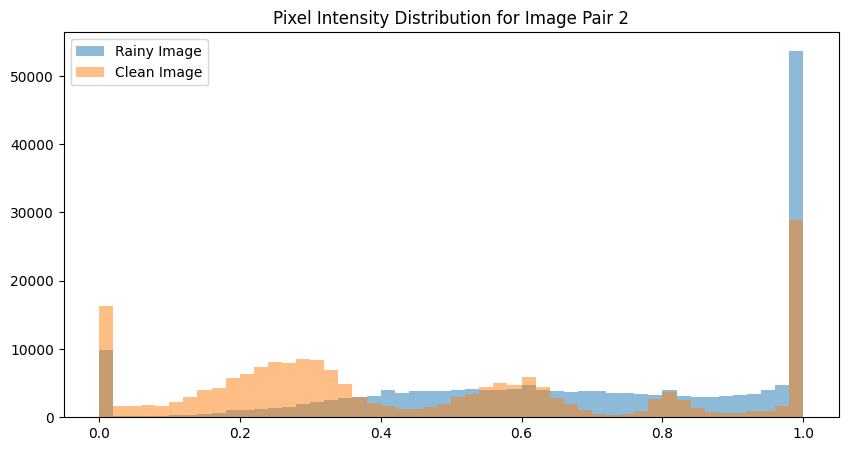

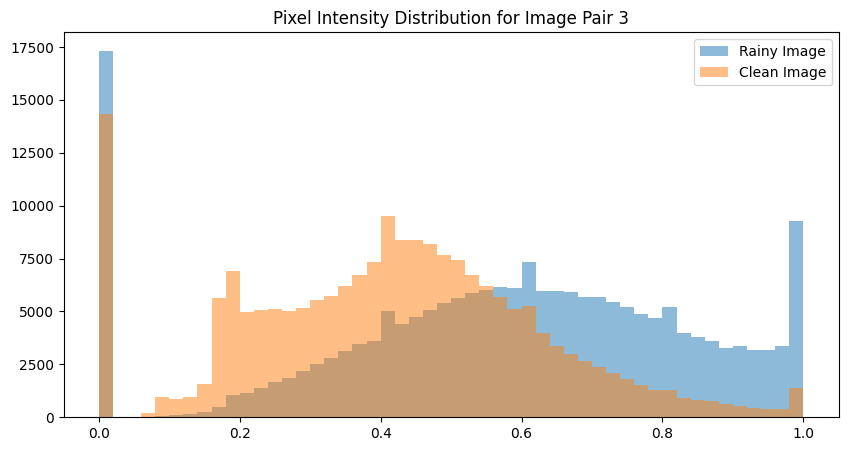

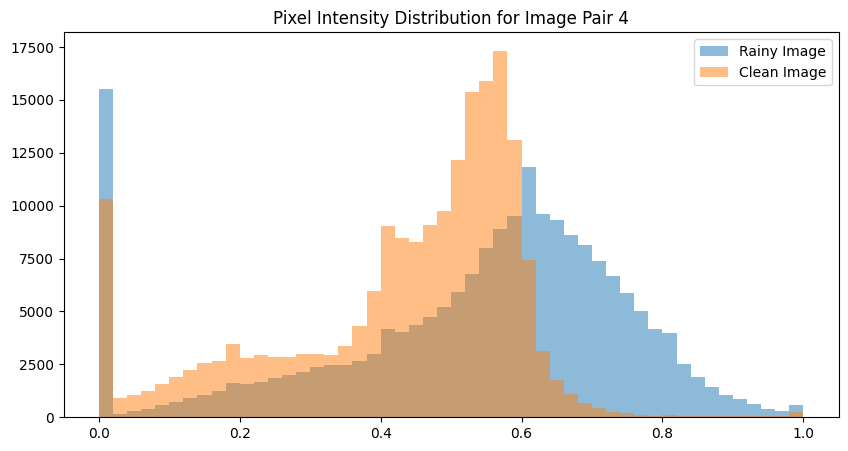

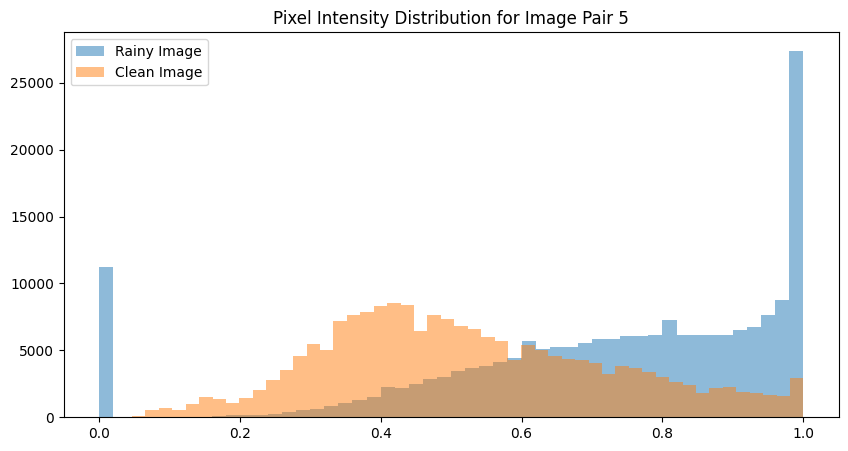

In [8]:
# Plot histograms of image pixel intensity distributions
def plot_pixel_intensity_histograms(dataset, num_images=5):
    for i in range(num_images):
        rain_img, clean_img = dataset[i]

        # Convert tensors back to numpy arrays (scale back from [-1, 1] to [0, 1] if normalized)
        rain_img_np = (rain_img.permute(1, 2, 0).numpy() * 0.5) + 0.5
        clean_img_np = (clean_img.permute(1, 2, 0).numpy() * 0.5) + 0.5

        # Flatten the image for histogram
        rain_img_flat = rain_img_np.flatten()
        clean_img_flat = clean_img_np.flatten()

        # Plot histograms
        plt.figure(figsize=(10, 5))
        plt.hist(rain_img_flat, bins=50, alpha=0.5, label="Rainy Image")
        plt.hist(clean_img_flat, bins=50, alpha=0.5, label="Clean Image")
        plt.legend()
        plt.title(f"Pixel Intensity Distribution for Image Pair {i+1}")
        plt.show()

# Plot pixel intensity histograms for 5 image pairs
plot_pixel_intensity_histograms(train_dataset, num_images=5)

In [9]:
# Calculate the average pixel intensity difference between rainy and clean images
def calculate_avg_pixel_intensity_difference(dataset, num_images=5):
    for i in range(num_images):
        rain_img, clean_img = dataset[i]

        # Convert tensors back to numpy arrays
        rain_img_np = (rain_img.permute(1, 2, 0).numpy() * 0.5) + 0.5
        clean_img_np = (clean_img.permute(1, 2, 0).numpy() * 0.5) + 0.5

        # Calculate absolute pixel-wise difference
        difference = np.abs(rain_img_np - clean_img_np)
        avg_diff = np.mean(difference)

        print(f"Average Pixel Intensity Difference for Image Pair {i+1}: {avg_diff:.4f}")

# Calculate average pixel intensity differences for 5 image pairs
calculate_avg_pixel_intensity_difference(train_dataset, num_images=5)

Average Pixel Intensity Difference for Image Pair 1: 0.2532
Average Pixel Intensity Difference for Image Pair 2: 0.2797
Average Pixel Intensity Difference for Image Pair 3: 0.2174
Average Pixel Intensity Difference for Image Pair 4: 0.1629
Average Pixel Intensity Difference for Image Pair 5: 0.2981


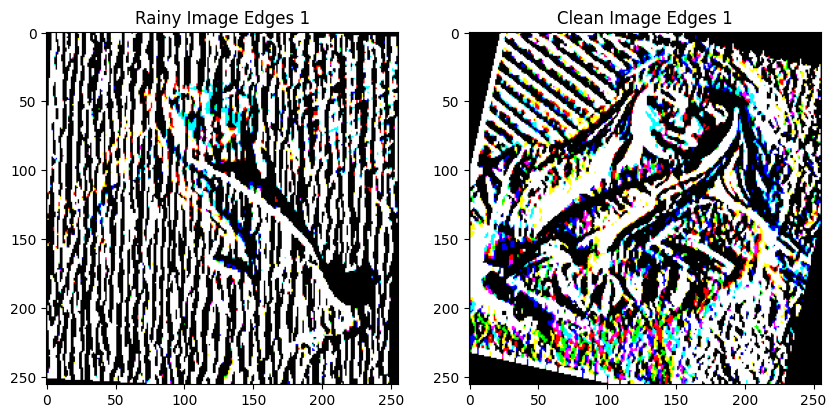

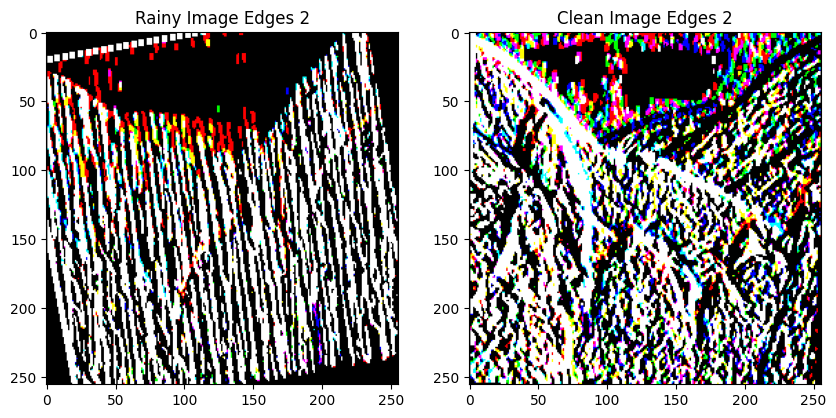

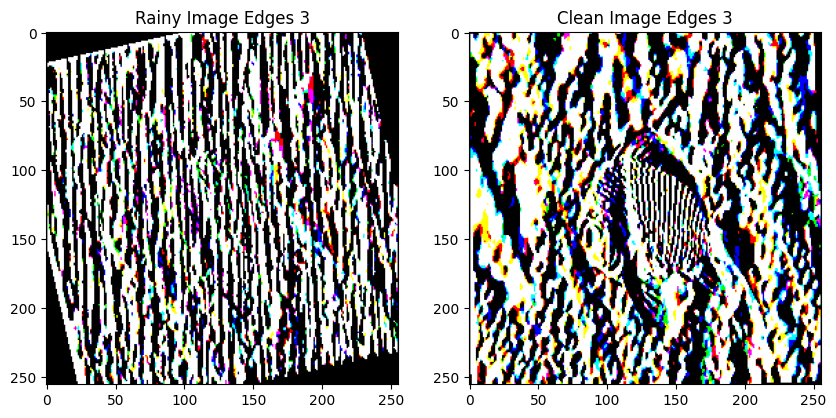

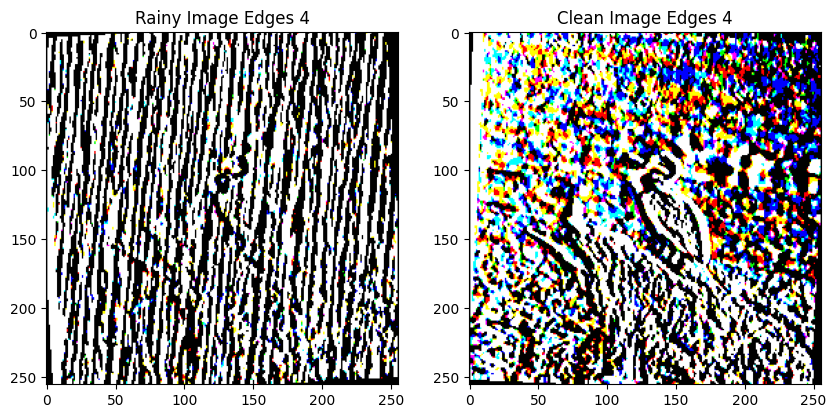

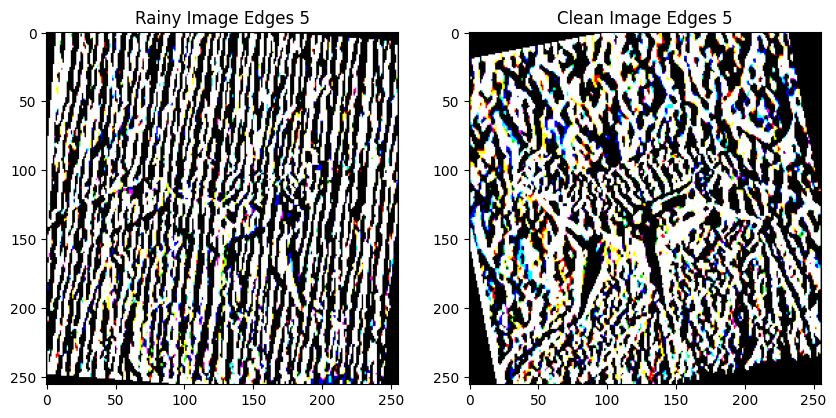

In [10]:
# Use convolutional filters to determine common characteristics
def apply_convolutional_filters(dataset, num_images=5):
    for i in range(num_images):
        rain_img, clean_img = dataset[i]

        # Convert tensors to numpy and scale to [0, 255] range
        rain_img_np = (rain_img.permute(1, 2, 0).numpy() * 0.5 + 0.5) * 255
        clean_img_np = (clean_img.permute(1, 2, 0).numpy() * 0.5 + 0.5) * 255

        # Apply Sobel filter (edge detection)
        rain_edges = cv2.Sobel(rain_img_np, cv2.CV_64F, 1, 0, ksize=5)
        clean_edges = cv2.Sobel(clean_img_np, cv2.CV_64F, 1, 0, ksize=5)

        # Display results
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(rain_edges)
        axes[0].set_title(f"Rainy Image Edges {i+1}")
        axes[1].imshow(clean_edges)
        axes[1].set_title(f"Clean Image Edges {i+1}")
        plt.show()

# Apply convolutional filters for 5 image pairs
apply_convolutional_filters(train_dataset, num_images=5)

Build the Autoencoder Model

Encoder: Compresses the rainy image into a latent space representation.
Decoder: Reconstructs the clean image from the compressed representation.

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # output: [64, 128, 128]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # output: [128, 64, 64]
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # output: [256, 32, 32]
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # output: [512, 16, 16]
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # output: [256, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # output: [128, 64, 64]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # output: [64, 128, 128]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),  # output: [3, 256, 256]
            nn.Tanh(),  # Pixel values will be in [-1, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate the model and move to device
model = Autoencoder().to(device)


 **Training the Model**
Define the training loop with MSE Loss function and the Adam optimizer.
this will help to Make sure the pixel values are normalized.

In [12]:
# Define the loss function and optimizer
criterion = nn.MSELoss()  # Could also use MAE loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
def train_autoencoder(model, dataloader, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for rain_img, clean_img in dataloader:
            rain_img, clean_img = rain_img.to(device), clean_img.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(rain_img)
            loss = criterion(outputs, clean_img)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

# Train the model
train_autoencoder(model, train_loader, num_epochs=20)


Epoch [1/20], Loss: 0.1878
Epoch [2/20], Loss: 0.1650
Epoch [3/20], Loss: 0.1597
Epoch [4/20], Loss: 0.1523
Epoch [5/20], Loss: 0.1466
Epoch [6/20], Loss: 0.1461
Epoch [7/20], Loss: 0.1468
Epoch [8/20], Loss: 0.1438
Epoch [9/20], Loss: 0.1447
Epoch [10/20], Loss: 0.1423
Epoch [11/20], Loss: 0.1419
Epoch [12/20], Loss: 0.1412
Epoch [13/20], Loss: 0.1427
Epoch [14/20], Loss: 0.1421
Epoch [15/20], Loss: 0.1402
Epoch [16/20], Loss: 0.1416
Epoch [17/20], Loss: 0.1406
Epoch [18/20], Loss: 0.1394
Epoch [19/20], Loss: 0.1387
Epoch [20/20], Loss: 0.1395


**Diagnostics and Performance Metrics**
After training, you’ll want to monitor model performance. You can diagnose performance through:

Loss Curves: Plot training loss over epochs to observe the convergence.
PSNR (Peak Signal-to-Noise Ratio): A higher PSNR between the predicted and clean image indicates better performance.
SSIM (Structural Similarity Index): Evaluates the perceived quality by comparing structural information between images.

In [14]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def evaluate_model(model, dataloader):
    model.eval()
    avg_psnr = 0.0
    avg_ssim = 0.0
    num_images = 0

    with torch.no_grad():
        for rain_img, clean_img in dataloader:
            rain_img = rain_img.to(device)
            clean_img = clean_img.to(device)

            # Forward pass through the model
            outputs = model(rain_img)

            # Detach and convert to numpy for PSNR and SSIM calculation
            outputs = outputs.cpu().numpy().transpose(0, 2, 3, 1)
            clean_img = clean_img.cpu().numpy().transpose(0, 2, 3, 1)

            for i in range(outputs.shape[0]):  # Iterate over the batch
                # Calculate PSNR and SSIM for each image
                psnr = peak_signal_noise_ratio(clean_img[i], outputs[i], data_range=1.0)  # Assuming images are normalized to [0, 1]

                # Manually specify window size, channel axis, and data range for SSIM
                ssim = structural_similarity(clean_img[i], outputs[i], channel_axis=2, win_size=11, data_range=1.0)

                avg_psnr += psnr
                avg_ssim += ssim
                num_images += 1

    avg_psnr /= num_images
    avg_ssim /= num_images
    print(f"Average PSNR: {avg_psnr:.4f}, Average SSIM: {avg_ssim:.4f}")

# Evaluate the model on the test set
evaluate_model(model, test_loader)

Average PSNR: 9.5225, Average SSIM: 0.1273


In [17]:
# Save entire model
torch.save(model, 'model_full_autoencoder_model_De_raining.pth')

# Save only state dict
torch.save(model.state_dict(), 'model_weights_autoencoder_model_De_raining.pth')

In [18]:
from google.colab import files

# Download the saved model files
files.download('model_full_autoencoder_model_De_raining.pth')
files.download('model_weights_autoencoder_model_De_raining.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>